In [1]:
%matplotlib inline
from pprint import pprint
from metrics import wer, cew, ssr, average, hreff
import montecarlo
import dms
import withdrawal
import mortality
from portfolio import Portfolio
from harvesting import make_rebalancer, PrimeHarvesting
from decimal import Decimal as D

import plot
from matplotlib import pyplot as plt

import pandas

In [2]:
survival_function = mortality.make_mortality(mortality.ANNUITY_2000)

In [3]:
HREFF_FLOOR = 3

def run_one(basecase, factory):
    # The montecarlo used above has the stock/bond split baked in
    # So we pretend we have a 100% stock portfolio in order to handle
    # harvesting of cash
    p = Portfolio(600000, 400000)
    h = make_rebalancer(.6)(p).harvest()
    #h = PrimeHarvesting(p).harvest()
    h.send(None)
    w = factory(p, h).withdrawals()

    cashflows = []
    returns = []
    
    # the previous year's returns
    x = None

    for i in range(mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_function)):
        # Withdrawals happen at the start of the year
        # So we first withdraw cash.
        cashflows.append(w.send(x).withdraw_pct_orig)
        
        # Then the year happens and we store the returns
        x = basecase.random_year()
        returns.append(x.stocks)

    w = wer(cashflows, returns)
    h = hreff(cashflows, returns, floor=D(HREFF_FLOOR)/100)
    return (w, h)

In [4]:
def calc(factory):
    runs = 1000
    dataset = montecarlo.conservative[60]
    wers = []
    for i in range(runs):
        wers.append(run_one(dataset, factory))
    wer = average([w[0] for w in wers])
    hreff = average([w[1] for w in wers])
    return (wer, hreff)

In [10]:
sensible_wer, sensible_hreff = calc(withdrawal.SensibleWithdrawals)

In [5]:
tilt_wer, tilt_hreff = calc(withdrawal.TiltCapital)

In [6]:
rmd_wer, rmd_hreff = calc(withdrawal.IRS_RMD)

In [7]:
feel_wer, feel_hreff = calc(withdrawal.FeelFree)

In [8]:
arva_wer, arva_hreff = calc(lambda p, h: withdrawal.ARVA(p, h, discount_rate=D('.02')))

In [9]:
vpw_wer, vpw_hreff = calc(lambda p, h: withdrawal.VPW(p, h, replan=True))

In [11]:
inverted_wer, inverted_hreff = calc(withdrawal.InvertedWithdrawals)

In [12]:
simple_wer, simple_hreff = calc(withdrawal.SimpleFormula)

In [13]:
retrench_wer, retrench_hreff = calc(withdrawal.RetrenchmentRule)

In [14]:
endowment_wer, endowment_hreff = calc(withdrawal.ConstantPercentage)

In [15]:
swr_wer, swr_hreff = calc(withdrawal.ConstantWithdrawals)

In [16]:
em_wer, em_hreff = calc(withdrawal.EM)

In [17]:
ecm_wer, ecm_hreff = calc(withdrawal.ECM)

ARVA           0.499267
Simple         0.535882
Sensible       0.543269
Inverted       0.546853
Constant 4%    0.557953
Feel Free      0.615950
Retrench       0.660661
RMD            0.677300
Endowment      0.677626
Tilt 1/3       0.686891
VPW            0.710343
ECM            0.713065
EM             0.724635
dtype: float64


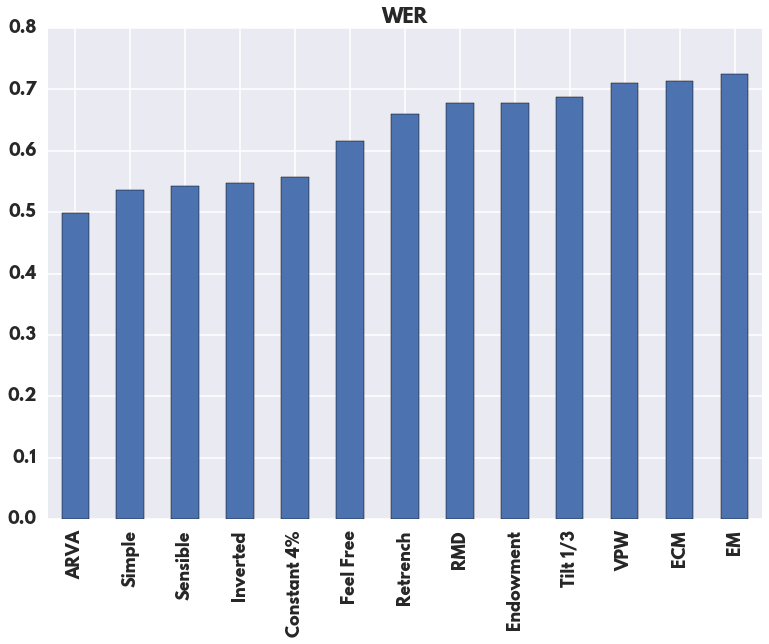

In [18]:
series = pandas.Series({
    'Constant 4%' : swr_wer,
    'Endowment' : endowment_wer,
    'EM' : em_wer,
    'VPW' : vpw_wer,
    'Simple' : simple_wer,
    'Retrench' : retrench_wer,
    'Sensible' : sensible_wer,
    'Inverted' : inverted_wer,
    'ECM' : ecm_wer,
    'ARVA' : arva_wer,
    'Feel Free': feel_wer,
    'RMD' : rmd_wer,
    'Tilt 1/3' : tilt_wer,
})

series.sort_values(inplace=True)
series.plot(kind='bar', title='WER')
print(series)

ARVA           0.102278
Inverted       0.207264
Sensible       0.252494
Feel Free      0.410388
Retrench       0.463320
Simple         0.501205
Endowment      0.507881
Tilt 1/3       0.541788
Constant 4%    0.560067
RMD            0.569076
VPW            0.578549
ECM            0.616780
EM             0.620377
dtype: float64


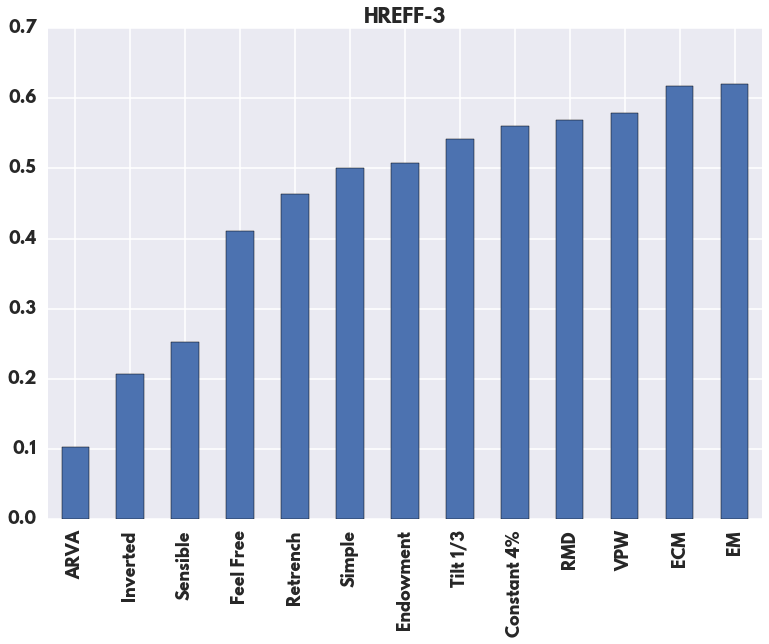

In [19]:
series = pandas.Series({
    'Constant 4%' : swr_hreff,
    'Endowment' : endowment_hreff,
    'EM' : em_hreff,
    'VPW' : vpw_hreff,
    'Simple' : simple_hreff,
    'Retrench' : retrench_hreff,
    'Sensible' : sensible_hreff,
    'Inverted' : inverted_hreff,
    'ECM' : ecm_hreff,
    'ARVA' : arva_hreff,
    'Feel Free' : feel_hreff,
    'RMD' : rmd_hreff,
    'Tilt 1/3' : tilt_hreff,
})

series.sort_values(inplace=True)
series.plot(kind='bar', title='HREFF-%s' % HREFF_FLOOR)
print(series)

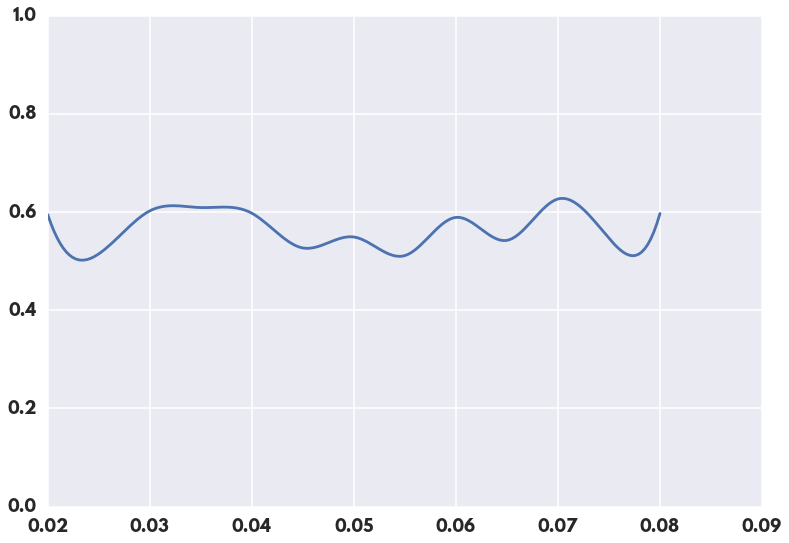

In [20]:
from scipy.interpolate import spline
import numpy as np

#canvas = plt.figure()

for equity in [0]:
    w = []
    r = []
    for rate in range(20, 81, 5):
        rate = D(rate) / 1000
        case = montecarlo.conservative[equity]

        wers = []
        for i in range(100):
            wers.append(run_one(case, withdrawal.ConstantWithdrawals))
        my_wer = average([w[0] for w in wers])
        w.append(my_wer)
        r.append(rate)

    x_smooth = np.linspace(float(min(r)), float(max(r)), 200)
    y_smooth = spline(r, w, x_smooth)

    fig, ax1 = plt.subplots()
    ax1.set_ylim((0,1))
    plt.plot(x_smooth, y_smooth)